In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scipy
plt.rcParams.update({
    "text.usetex": True,   
    "font.family": "DejaVu Sans",
    "font.size": 18,
    'figure.autolayout': True,
    'legend.fontsize': 14})

In [3]:
# read experimental data
df_mu = pd.read_csv("mu.csv")
z_exp = np.array(df_mu["z"])
mu_exp = np.array(df_mu["mu"])
error_exp = np.array(df_mu["error"])

experimental = np.array([z_exp, mu_exp, error_exp])

In [4]:
# km/s/Mpc units
h_0 = 67.36

# 1/Gyr units
h_0 = h_0*(1/3.086e+19)*(60*60*24*365)

# density parameters L-CDM
om_g0 = 5.446e-5*1.681
om_m0 = 0.3153 - om_g0
om_l0 = 1 - (om_m0 + om_g0)

# density parameters array for L-CDM
params = [om_m0,om_l0,om_g0]

# integral resolution
resolution = 10000

In [5]:
# define the function a' = f(t,a) (L-CDM model)
def adot_lcdm(a,params):
    return h_0*np.sqrt(params[0]*a**(-1) + params[1]*a**(2) + params[2]*a**(-2))

In [6]:
# define numerical integration simpson's method 
def integral_simpson(f,t):
    t_new = []
    integral = []
    integral_sum = 0
    for i in range(len(t)-1):
        t_new_point = (t[i] + t[i+1])/2
        t_new.append(t_new_point)
        integral_sum += (t[i+1] - t[i])*(f[i+1] + f[i])/2
        integral.append(integral_sum)
    return np.array(integral), np.array(t_new)

In [7]:
# define distance modulus function
def mu_z(om_m0, om_g0):
    # make sure the sum of parameters equals 1
    params = [om_m0, 1-(om_m0 + om_g0), om_g0]
    
    # compute proper distance
    #z = np.linspace(0.0005,2.0005,20001)
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)

    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0

    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)

    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    
    return mu, z_new

In [8]:
# define chi squared
def chi_sq(om):
    # return high value if density parameters are >1 or <0
    if(om[0] < 0 or om[1] < 0 or om[0] > 1 or om[1] > 1):
        return 10e20
    sum = 0
    mu, z = mu_z(om[0],om[1])
    for i in range(len(experimental[0])):
        sum += (mu[int(round(experimental[0][i]*resolution-1,0))] - experimental[1][i])**2/experimental[2][i]**2
    return sum

In [9]:
# define chi squared matter only
def chi_sq_m(om_m0):
    # return high value if matter density parameter is >1 or <0
    if(om_m0 < 0 or om_m0 > 1):
        return 10e20
    om_g0 = 0
    sum = 0
    mu, z = mu_z(om_m0,om_g0)
    for i in range(len(experimental[0])):
        sum += (mu[int(round(experimental[0][i]*resolution-1,0))] - experimental[1][i])**2/experimental[2][i]**2
    return sum

In [10]:
min_m = scipy.minimize(chi_sq_m, 0.3)
omm = np.array([min_m.x[0], 1 - min_m.x[0], 0])
omm

array([0.39673576, 0.60326424, 0.        ])

In [11]:
min_mr = scipy.minimize(chi_sq,[0.3,0.0001])
ommr = np.array([min_mr.x[0], 1 - (min_mr.x[0] + min_mr.x[1]), min_mr.x[1]])
ommr

array([0.46568618, 0.52943982, 0.004874  ])

In [12]:
mu_mr, z_mr = mu_z(ommr[0], ommr[2])
mu_m, z_m = mu_z(omm[0],0)
mu_lcdm, z_lcdm = mu_z(0.3153, 5.446e-5*1.681)

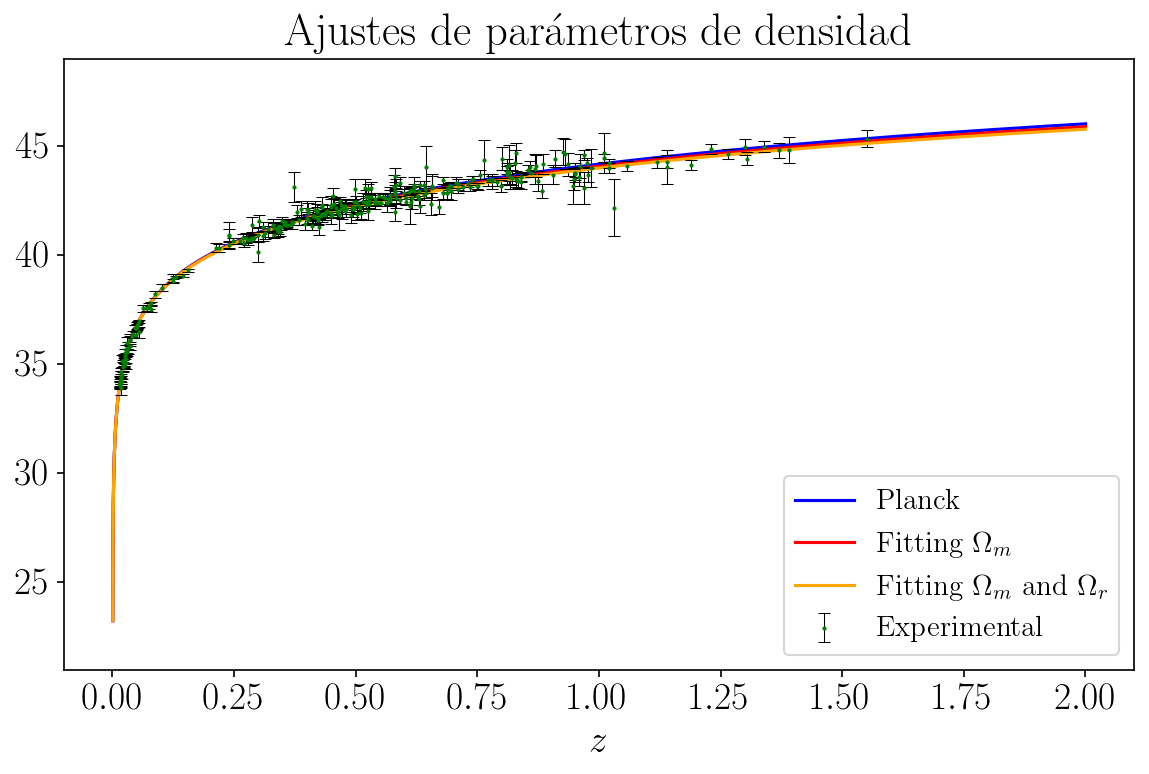

In [13]:
fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)

ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck")
ax.plot(z_m,mu_m,"r",label=r"Fitting $\Omega_m$")
ax.plot(z_mr,mu_mr,"orange",label=r"Fitting $\Omega_m$ and $\Omega_r$")
ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",color="b",ms=2,label=r"Experimental")

ax.set_ylim(21,49)
ax.set_xlim(-0.1,2.1)

#ax.grid()
ax.set_xlabel(r"$z$")
#ax.set_ylabel(r"1/years")
ax.set_title(r"Ajustes de parámetros de densidad")
plt.legend(fontsize=14)
plt.savefig("ajustes.png")